In [19]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
import os 

import config as cfg

In [20]:
batch_size = 1024 * 16

In [21]:
train_n_validation = pd.read_csv(os.path.join(cfg.csv_dir, 'train_n_validation_multilabel.csv'))

In [22]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [23]:
np.random.seed(42)

src = (ImageList.from_df(path=cfg.img_path, df=train_n_validation, folder='all')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [24]:
data = (src.transform(tfms, size=224)
        .databunch().normalize(imagenet_stats))


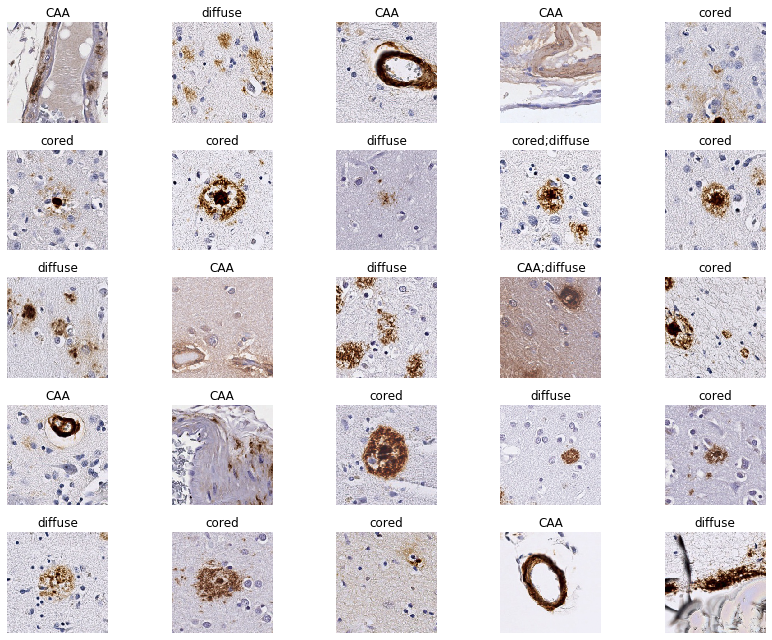

In [25]:
data.show_batch(rows=5, figsize=(12,9))

In [26]:
from fastai.callbacks.tracker import SaveModelCallback, EarlyStoppingCallback

class SaveModelCallbackToDest(SaveModelCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best to specific path."
    def __init__(self,
                 learn:Learner,
                 monitor:str='valid_loss',
                 mode:str='auto',
                 every:str='improvement',
                 name:str='bestmodel',
                 dest:str=None):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name, self.dest = every,name,dest
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
    
    def on_epoch_end(self, epoch:int, **kwargs:Any)->None:
        
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": self.learn.save(os.path.join(self.dest, f'{self.name}_{epoch}'))
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                print(f'Better model found at epoch {epoch} with {self.monitor} value: {current}.')
                self.best = current
                self.learn.save(os.path.join(self.dest, f'{self.name}'))

In [27]:
resnet34 = models.resnet34

In [28]:
acc_05 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.2)

In [29]:
learn = cnn_learner(data, resnet34, metrics=[acc_05, f_score])

In [30]:
# learn = learn.to_fp16()
# This didn't speed up training?

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 1.45E-02


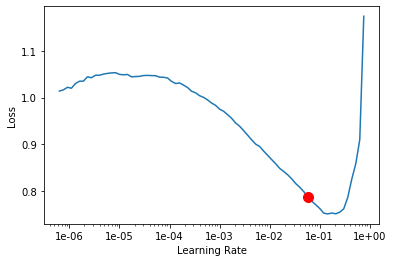

In [31]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [32]:
learn.fit_one_cycle(8, slice(1.45e-02), callbacks=[SaveModelCallbackToDest(learn,
                                                             every='improvement',
                                                             monitor='valid_loss',
                                                             name='rn34-stage1-v1',
                                                             dest=cfg.models_dir),
                                                         
                                                        ])


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.167237,0.150682,0.942010,0.927396,02:52
1,0.147945,0.132919,0.952591,0.935911,02:51
2,0.142433,0.132582,0.952812,0.937450,02:52
3,0.146635,0.114466,0.957160,0.944381,02:51
4,0.129626,0.110935,0.959784,0.946157,02:51
5,0.118468,0.108734,0.959265,0.947443,02:51
6,0.107571,0.094627,0.965970,0.954110,02:51
7,0.104771,0.093871,0.966474,0.954886,02:51


Better model found at epoch 0 with valid_loss value: 0.15068228542804718.
Better model found at epoch 1 with valid_loss value: 0.13291947543621063.
Better model found at epoch 2 with valid_loss value: 0.1325823962688446.
Better model found at epoch 3 with valid_loss value: 0.11446604132652283.
Better model found at epoch 4 with valid_loss value: 0.11093533039093018.
Better model found at epoch 5 with valid_loss value: 0.10873420536518097.
Better model found at epoch 6 with valid_loss value: 0.09462688863277435.
Better model found at epoch 7 with valid_loss value: 0.0938711166381836.


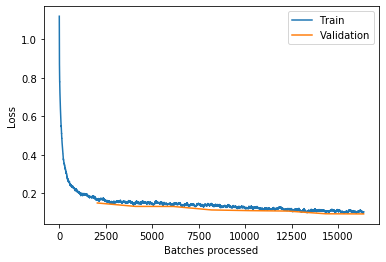

In [33]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 9.12E-08


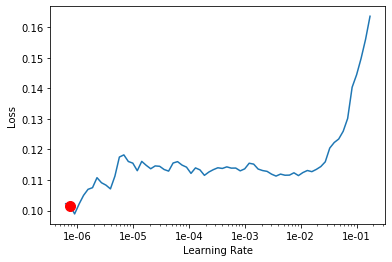

In [34]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [35]:
learn.fit_one_cycle(4, slice(1.45e-02), callbacks=[SaveModelCallbackToDest(learn,
                                                             every='improvement',
                                                             monitor='valid_loss',
                                                             name='rn34-stage1-v1',
                                                             dest=cfg.models_dir),
                                                         
                                                        ])


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.134567,0.109384,0.960776,0.945699,02:51
1,0.133342,0.113561,0.958853,0.946837,02:52
2,0.117894,0.097412,0.965833,0.952898,02:53
3,0.102338,0.092250,0.967321,0.955264,02:53


Better model found at epoch 0 with valid_loss value: 0.10938394069671631.
Better model found at epoch 2 with valid_loss value: 0.09741239994764328.
Better model found at epoch 3 with valid_loss value: 0.09224992245435715.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 1.00E-04


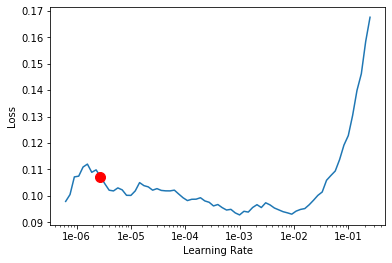

In [37]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [38]:
learn.fit_one_cycle(20, slice(1e-4), callbacks=[SaveModelCallbackToDest(learn,
                                                             every='improvement',
                                                             monitor='valid_loss',
                                                             name='rn34-stage2-v1',
                                                             dest=cfg.models_dir),
                                                         
                                                        ])



epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.104794,0.092774,0.966771,0.954791,02:52
1,0.102496,0.092328,0.967138,0.954934,02:53
2,0.103815,0.092458,0.967313,0.955532,02:52
3,0.106183,0.092026,0.967778,0.954907,02:52
4,0.105525,0.095226,0.967809,0.955453,02:52
5,0.108944,0.091069,0.968289,0.955974,02:53
6,0.107386,0.090891,0.968206,0.955743,02:53
7,0.107190,0.090888,0.968389,0.956133,02:53
8,0.104716,0.091173,0.968198,0.955183,02:53
9,0.099067,0.090859,0.968656,0.955624,02:52


Better model found at epoch 0 with valid_loss value: 0.09277421981096268.
Better model found at epoch 1 with valid_loss value: 0.09232781827449799.
Better model found at epoch 3 with valid_loss value: 0.09202615171670914.
Better model found at epoch 5 with valid_loss value: 0.09106909483671188.
Better model found at epoch 6 with valid_loss value: 0.09089148789644241.
Better model found at epoch 7 with valid_loss value: 0.09088844805955887.
Better model found at epoch 9 with valid_loss value: 0.09085879474878311.
Better model found at epoch 10 with valid_loss value: 0.09075859189033508.
Better model found at epoch 12 with valid_loss value: 0.08996348083019257.


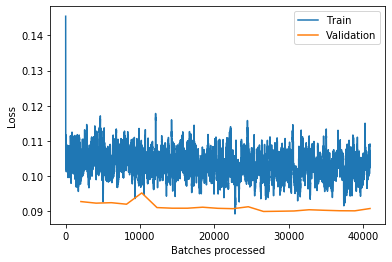

In [39]:
learn.recorder.plot_losses()

In [40]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 6.31E-08


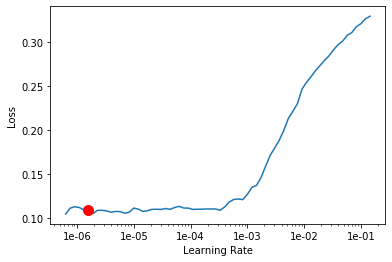

In [41]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
# EarlyStoppingCallback(learn,
#                                                                  monitor='valid_loss',
#                                                                  min_delta=0.1,
#                                                                  patience=4)

learn.fit_one_cycle(30, slice(1e-6, 1e-01/5), callbacks=[SaveModelCallbackToDest(learn,
                                                             every='improvement',
                                                             monitor='valid_loss',
                                                             name='rn34-stage1-v1',
                                                             dest=cfg.models_dir),
                                                         
                                                        ])

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.043147,0.048197,0.985163,0.977390,03:46
1,0.042664,0.049285,0.985369,0.977960,03:47
2,0.051965,0.056033,0.983386,0.974737,03:46
3,0.065050,0.068199,0.978290,0.969530,03:47
4,0.078208,0.073857,0.977481,0.966895,03:47
5,0.087613,0.078076,0.974949,0.965257,03:47
6,0.084085,0.081244,0.973896,0.963065,03:46
7,0.077422,0.085845,0.976162,0.965623,03:46
8,0.075137,0.100101,0.978954,0.967822,03:46
9,0.070287,0.068582,0.978916,0.969111,03:46


Better model found at epoch 0 with valid_loss value: 0.04819729924201965.


In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save(os.path.join(cfg.models_dir, 'rn34-stage1-v1'))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


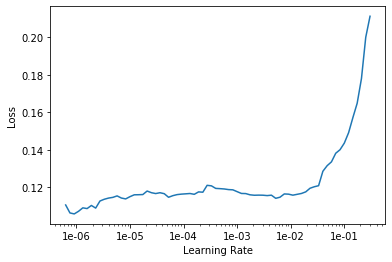

In [42]:
resnet50 = models.resnet50
learn50 = cnn_learner(data, resnet50, metrics=[acc_05, f_score])
learn.lr_find()
learn.recorder.plot()

In [43]:
lr50 = 1e-02

In [44]:
learn50.fit_one_cycle(2, slice(lr50))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.144298,0.130827,0.952186,0.938007,05:34
1,0.128029,0.109618,0.958830,0.945745,05:31


In [45]:
learn50.save(os.path.join(cfg.models_dir, 'stage-1-rn50-v3'))

In [46]:
learn50.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


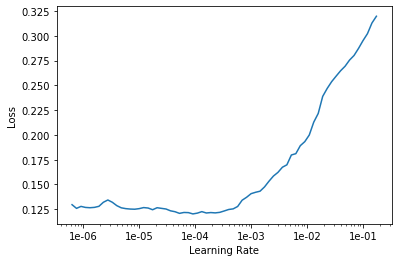

In [47]:
learn50.lr_find()
learn50.recorder.plot()

In [48]:
learn50.fit_one_cycle(5, slice(1e-5, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.137155,0.139620,0.949333,0.930537,07:53
1,0.125236,0.152772,0.960059,0.944449,07:45
2,0.091744,0.349414,0.970349,0.958063,07:46
3,0.074564,0.073083,0.979411,0.968622,07:46
4,0.063288,0.068320,0.981082,0.971431,07:46


In [49]:
learn50.save(os.path.join(cfg.models_dir, 'stage-2-rn50-v3'))

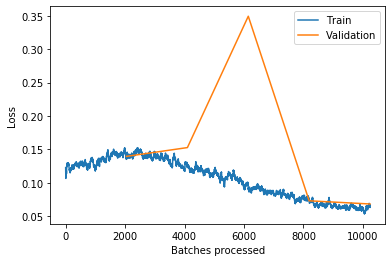

In [50]:
learn50.recorder.plot_losses()

In [51]:
learn50.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


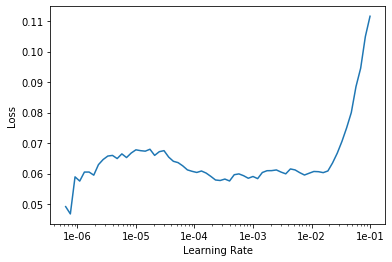

In [52]:
learn50.lr_find()
learn50.recorder.plot()

In [53]:
learn50.fit_one_cycle(2, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.072268,0.072741,0.980167,0.970301,05:27
1,0.071024,0.075032,0.981135,0.972245,05:30


In [54]:
learn50.save(os.path.join(cfg.models_dir, 'stage-3-rn50-v3'))

In [55]:
data_256 = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn50.data = data_256
data_256.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [56]:
learn50.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


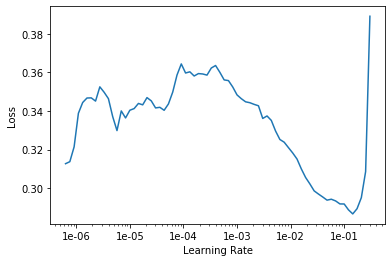

In [57]:
learn50.lr_find()
learn50.recorder.plot()

In [58]:
lr=1e-2
learn50.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.124932,0.115341,0.958403,0.945981,20:52
1,0.101864,0.134240,0.966176,0.952304,20:44
2,0.096036,0.125455,0.968877,0.956562,20:31


In [59]:
learn50.save(os.path.join(cfg.models_dir, 'stage-4-256-rn50'))

In [60]:
learn50.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


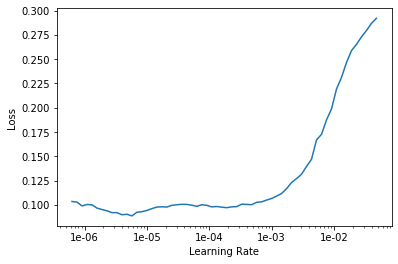

In [61]:
learn50.lr_find()
learn50.recorder.plot()

In [62]:
learn50.fit_one_cycle(2, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.097339,0.083388,0.972264,0.959751,27:48
1,0.079276,0.071440,0.978870,0.968229,27:54


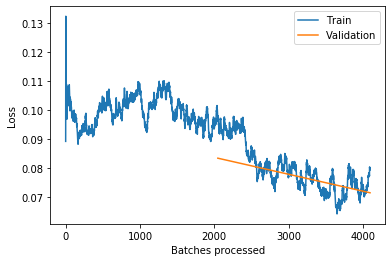

In [63]:
learn50.recorder.plot_losses()

In [64]:
learn50.save(os.path.join(cfg.models_dir, 'stage-5-256-rn50'))

In [65]:
learn50.export(os.path.join(cfg.models_dir, 'stage-5-256-rn50-exported'))